In [1]:
from sklearn import datasets
import pandas as pd
dataset = datasets.fetch_california_housing(as_frame = True)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(1)

dataset.frame_normalized = StandardScaler().fit_transform(dataset.frame)
# We drop Longitude as well since Latitude has enough information?
X = dataset.frame_normalized[:,0:len(dataset.frame.columns) - 2]
y = dataset.frame_normalized[:,len(dataset.frame.columns) - 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)
X_train = np.insert(X_train, 0, np.ones(X_train.shape[0]), axis=1)
X_test = np.insert(X_test, 0, np.ones(X_test.shape[0]), axis=1)

In [2]:
n = X_train.shape[0]
d = X_train.shape[1]
lbda = 1. / n ** (0.5)


In [3]:

from scipy.linalg import norm
# Python class for regression problems
class RegPb(object):
    '''
        A class for regression problems with linear models.
        
        Attributes:
            A: Data matrix (features)
            y: Data vector (labels)
            n,d: Dimensions of A
            loss: Loss function to be considered in the regression
                'l2': Least-squares loss
                'logit': Logistic loss
            lbda: Regularization parameter
    '''
   
    # Instantiate the class
    def __init__(self, A, y,lbda=0,loss='l2'):
        self.A = A
        self.y = y
        self.n, self.d = A.shape
        self.loss = loss
        self.lbda = lbda
        
    
    # Objective value
    def fun(self, x):
        if self.loss=='l2':
            return norm(self.A.dot(x) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            return np.mean(np.log(1. + np.exp(-yAx))) + self.lbda * norm(x) ** 2 / 2.
    
    # Partial objective value
    def f_i(self, i, x):
        if self.loss=='l2':
            return norm(self.A[i].dot(x) - self.y[i]) ** 2 / (2.) + self.lbda * norm(x) ** 2 / 2.
        elif self.loss=='logit':
            yAxi = self.y[i] * np.dot(self.A[i], x)
            return np.log(1. + np.exp(- yAxi)) + self.lbda * norm(x) ** 2 / 2.
    
    # Full gradient computation
    def grad(self, x):
        if self.loss=='l2':
            return self.A.T.dot(self.A.dot(x) - self.y) / self.n + self.lbda * x
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            aux = 1. / (1. + np.exp(yAx))
            return - (self.A.T).dot(self.y * aux) / self.n + self.lbda * x
    
    # Partial gradient
    def grad_i(self,i,x):
        a_i = self.A[i]
        if self.loss=='l2':
            return (a_i.dot(x) - self.y[i]) * a_i + self.lbda*x
        elif self.loss=='logit':
            grad = - a_i * self.y[i] / (1. + np.exp(self.y[i]* a_i.dot(x)))
            grad += self.lbda * x
            return grad
        
    # Partial gradient knowing the model (useful for certain gradient techniques)
    def grad_ai(self,i,aix,x=None):
        a_i = self.A[i]
        if self.loss=='l2':
            grad = (aix - self.y[i]) * a_i 
            if (self.lbda>0):
                grad += self.lbda*x
        elif self.loss=='logit':
            grad = - a_i * self.y[i] / (1. + np.exp(self.y[i]* aix))
            if (self.lbda>0):
                grad += self.lbda * x
        return grad        

    # Lipschitz constant for the gradient
    def lipgrad(self):
        if self.loss=='l2':
            L = norm(self.A, ord=2) ** 2 / self.n + self.lbda
        elif self.loss=='logit':
            L = norm(self.A, ord=2) ** 2 / (4. * self.n) + self.lbda
        return L
    
    # ''Strong'' convexity constant (could be zero if self.lbda=0)
    def cvxval(self):
        if self.loss=='l2':
            s = svdvals(self.A)
            mu = min(s)**2 / self.n 
            return mu + self.lbda
        elif self.loss=='logit':
            return self.lbda


In [4]:
#Create models using data
pblinreg = RegPb(X_train, y_train, lbda, loss='l2')

In [5]:
# Check correctness of the gradient functions compared to a finite-difference 
# estimate. Note: this is a check of the implementation of the gradient and the 
# function value. If correct, the output value, which represents the difference 
# between a gradient and its estimation from function values, should be of order 
# 1e-06 at most.


In [6]:
# check_grad_calculations(pblinreg, pblogreg, n, d)
from scipy.optimize import check_grad
print(check_grad(pblinreg.fun, pblinreg.grad, np.random.randn(d)))
grad_error = []
for i in range(n):
    ind = np.random.choice(n,1)
    w =  np.random.randn(d)
    vec =  np.random.randn(d)
    eps = pow(10.0, -7.0)
    grad_error.append((pblinreg.f_i( ind[0], w+eps*vec) - pblinreg.f_i( ind[0], w))/eps - np.dot(pblinreg.grad_i(ind[0],w),vec)) 
print(np.mean(grad_error))

6.829000237098505e-07
3.5135256572119076e-07


Simple loss function + moderate # points --> 2nd order method is viable.
Computes target objective and target weight vector

In [7]:
from scipy.optimize import fmin_l_bfgs_b
x_init = np.zeros(d)
# Compute the optimal solution for linear regression
x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg.grad(x_min_lin)))

0.23022292245197012
9.447895764557707e-09


These solutions will enable us to study the behavior of the distance to optimality in terms of function values 
$f(\mathbf{x}_k)-f^*$ and iterates $\|\mathbf{x}_k -\mathbf{x}^*\|$. 

*Note: Recall that $\|\nabla f(\mathbf{x}_k)\| \ge 2 \mu (f(\mathbf{x}_k)-f^*)$ for a $\mu$-strongly convex, continuously differentiable function with optimal value $f^*$, thus the gradient could also be used as an upper estimate of the distance to optimality in terms of function values. In terms of access to data points, however, both quantities are expensive.*

In [8]:
def stoch_grad(x0,problem,xtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,average=0,scaling=0,with_replace=False,verbose=True): 
    """
        A code for gradient descent with various step choices.
        
        Inputs:
            x0: Initial vector
            problem: Problem structure
                problem.fun() returns the objective function, which is assumed to be a finite sum of functions
                problem.n returns the number of components in the finite sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
                problem.lambda returns the value of the regularization parameter
            xtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                1: Step size decreasing in 1/sqrt(k+1)
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            nb: Number of components drawn per iteration/Batch size 
                1: Classical stochastic gradient algorithm (default value)
                problem.n: Classical gradient descent (default value)
            average: Indicates whether the method computes the average of the iterates 
                0: No averaging (default)
                1: With averaging
            scaling: Use a diagonal scaling
                0: No scaling (default)
                1: Average of magnitudes (RMSProp)
                2: Normalization with magnitudes (Adagrad)
            with_replace: Boolean indicating whether components are drawn with or without replacement
                True: Components drawn with replacement
                False: Components drawn without replacement (Default)
            verbose: Boolean indicating whether information should be plot at every iteration (Default: False)
            
        Outputs:
            x_output: Final iterate of the method (or average if average=1)
            objvals: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Number of samples
    n = problem.n
    
    # Initial value of current iterate  
    x = x0.copy()
    nx = norm(x)
    
    # Average (if needed)
    if average:
            xavg=np.zeros(len(x))
    
    #Scaling values
    if scaling>0:
        mu=1/(2 *(n ** (0.5)))
        v = np.zeros(d)
        beta = 0.8

    # Initialize iteration counter
    k=0
    
    # Current objective
    obj = problem.fun(x) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(x-xtarget)
    normits.append(nmin)
    

    if verbose:
        # Plot initial quantities of interest
        print("Stochastic Gradient, batch size=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter and nx < 10**100):
        # Draw the batch indices
        ik = np.random.choice(n,nb,replace=with_replace)# Batch gradient
        # Stochastic gradient calculation
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],x)
            sg = sg + gi
        sg = (1/nb)*sg
        
        if scaling>0:
            if scaling==1:
                # RMSProp update
                v = beta*v + (1-beta)*sg*sg
            elif scaling==2:
                # Adagrad update
                v = v + sg*sg 
            sg = sg/(np.sqrt(v+mu))

        if stepchoice==0:
            x[:] = x - (step0/L) * sg
        elif stepchoice==1:
            sk = float(step0/(np.sqrt(k+1)))
            x[:] = x - sk * sg
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            x[:] = x - sk * sg
        
        nx = norm(x) #Computing the norm to measure divergence 
        
        if average:
            # If average, compute the average of the iterates
            xavg = k/(k+1) *xavg + x/(k+1) 
            nmin = norm(xavg-xtarget)
            obj = problem.fun(xavg)
        else:
            obj = problem.fun(x)
            nmin = norm(x-xtarget)
        
       
        
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))     
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    if average:
        x_output = xavg.copy()
    else:
        x_output = x.copy()
    
    return x_output, np.array(objvals), np.array(normits)



In [9]:
# Compare implementations of gradient descent/stochastic gradient
# Pay attention to the budget allocated to each solver (the cost of one iteration of gradient descent vs 
# the cost of 1 iteration of stochastic gradient are different)

nb_epochs = 60
n = pblinreg.n
nbset = 1
x0 = np.zeros(d)

# Run a - Gradient descent with constant stepsize
x_d, obj_d, nits_d = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0,step0=1, n_iter=nb_epochs,nb=n)
# Run b - Stochastic gradient with constant stepsize
# The version below may diverges, in which case the bound on norm(w) in the code will be triggered
x_b, obj_b, nits_b = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0,step0=1, n_iter=int(nb_epochs*n/nbset),nb=1, verbose=True)
# Run Gradient descent with decreasing stepsize
x_c, obj_c, nits_c = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs,nb=n)
# Run Stochastic gradient with decreasing stepsize
x_a, obj_a, nits_a = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)
#Make a so don't have to rerun below

Stochastic Gradient, batch size= 16512 / 16512
  iter   |   fval   |  normit 
       0 | 4.99e-01 | 1.03e+00
       1 | 2.84e-01 | 7.84e-01
       2 | 2.54e-01 | 7.14e-01
       3 | 2.47e-01 | 6.77e-01
       4 | 2.45e-01 | 6.47e-01
       5 | 2.43e-01 | 6.20e-01
       6 | 2.42e-01 | 5.95e-01
       7 | 2.41e-01 | 5.70e-01
       8 | 2.40e-01 | 5.47e-01
       9 | 2.39e-01 | 5.25e-01
      10 | 2.39e-01 | 5.04e-01
      11 | 2.38e-01 | 4.83e-01
      12 | 2.37e-01 | 4.63e-01
      13 | 2.37e-01 | 4.45e-01
      14 | 2.36e-01 | 4.27e-01
      15 | 2.36e-01 | 4.09e-01
      16 | 2.35e-01 | 3.93e-01
      17 | 2.35e-01 | 3.77e-01
      18 | 2.35e-01 | 3.61e-01
      19 | 2.34e-01 | 3.47e-01
      20 | 2.34e-01 | 3.33e-01
      21 | 2.34e-01 | 3.19e-01
      22 | 2.33e-01 | 3.06e-01
      23 | 2.33e-01 | 2.94e-01
      24 | 2.33e-01 | 2.82e-01
      25 | 2.33e-01 | 2.70e-01
      26 | 2.32e-01 | 2.59e-01
      27 | 2.32e-01 | 2.49e-01
      28 | 2.32e-01 | 2.39e-01
      29 | 2.32e-01 | 2

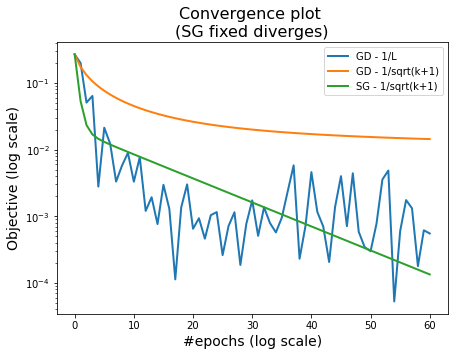

In [10]:
# Plot the comparison of variants of GD/SG with the same stepsize rule
# NB: The x-axis is in epochs (1 iteration of GD).
import matplotlib.pyplot as plt
# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="GD - 1/L", lw=2)
# plt.semilogy(obj_b-f_min_lin, label="SG - 1/L", lw=2)
plt.semilogy(obj_c-f_min_lin, label="GD - 1/sqrt(k+1)", lw=2)
plt.semilogy(obj_d-f_min_lin, label="SG - 1/sqrt(k+1)", lw=2)
plt.title("Convergence plot \n(SG fixed diverges)", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend();

*Question 2:* Find a value for the batch size that realizes a good compromise between gradient descent and stochastic gradient.

### Experimenting with batch size

In [11]:
# Test several values for the batch size using the same epoch budget.

nb_epochs = 20
n = pblinreg.n
x0 = np.zeros(d)

replace_batch=False

# Stochastic gradient (batch size 1)
x_a, obj_a, nits_a = x_a, obj_a, nits_a
# x_a, obj_a, nits_a = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)

# Batch stochastic gradient (batch size n/100)
nbset=int(n/100)
x_b, obj_b, nits_b = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset)

# Batch stochastic gradient (batch size n/10)
nbset=int(n/10)
x_c, obj_c, nits_c = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset)

# Batch stochastic gradient (batch size n/2)
nbset=int(n/2)
x_d, obj_d, nits_d = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset)

# Gradient descent (batch size n, taken without replacement)
x_f, obj_f, nits_f = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs),nb=n)

Stochastic Gradient, batch size= 165 / 16512
  iter   |   fval   |  normit 
       0 | 4.99e-01 | 1.03e+00
    2001 | 2.32e-01 | 2.30e-01
Stochastic Gradient, batch size= 1651 / 16512
  iter   |   fval   |  normit 
       0 | 4.99e-01 | 1.03e+00
     200 | 2.40e-01 | 5.30e-01
Stochastic Gradient, batch size= 8256 / 16512
  iter   |   fval   |  normit 
       0 | 4.99e-01 | 1.03e+00
       2 | 3.61e-01 | 8.85e-01
       4 | 3.19e-01 | 8.28e-01
       6 | 2.97e-01 | 7.94e-01
       8 | 2.84e-01 | 7.71e-01
      10 | 2.75e-01 | 7.54e-01
      12 | 2.69e-01 | 7.40e-01
      14 | 2.64e-01 | 7.29e-01
      16 | 2.61e-01 | 7.20e-01
      18 | 2.58e-01 | 7.12e-01
      20 | 2.56e-01 | 7.05e-01
      22 | 2.55e-01 | 6.99e-01
      24 | 2.53e-01 | 6.93e-01
      26 | 2.52e-01 | 6.88e-01
      28 | 2.51e-01 | 6.84e-01
      30 | 2.50e-01 | 6.79e-01
      32 | 2.49e-01 | 6.75e-01
      34 | 2.49e-01 | 6.71e-01
      36 | 2.48e-01 | 6.67e-01
      38 | 2.48e-01 | 6.64e-01
      40 | 2.47e-01 | 6.60

In [12]:
# Batch stochastic gradient (batch size n/2)
nbset=int(n/5)
x_e, obj_e, nits_e = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset)

Stochastic Gradient, batch size= 3302 / 16512
  iter   |   fval   |  normit 
       0 | 4.99e-01 | 1.03e+00
     100 | 2.42e-01 | 5.95e-01


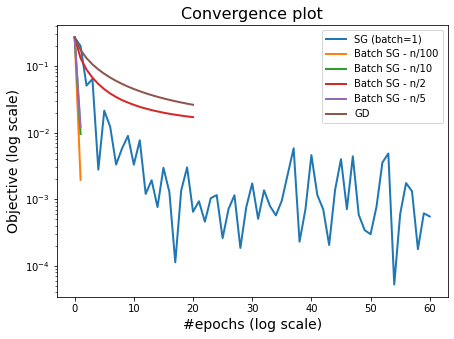

In [13]:
# Plot the comparison of variants of batch SGD with the same stepsize rule

# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="SG (batch=1)", lw=2)
plt.semilogy(obj_b-f_min_lin, label="Batch SG - n/100", lw=2)
plt.semilogy(obj_c-f_min_lin, label="Batch SG - n/10", lw=2)
plt.semilogy(obj_d-f_min_lin, label="Batch SG - n/2", lw=2)
plt.semilogy(obj_e-f_min_lin, label="Batch SG - n/5", lw=2)
plt.semilogy(obj_f-f_min_lin, label="GD", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend();

## *Question 3:* 

Compare your stochastic gradient method with one of the advanced variants seen in class on your selected problem. Discuss your results, and what interpretation you can draw from them.

For Averaging
(Only 2 reps because big dataset)

Stochastic Gradient, batch size= 16 / 16512
  iter   |   fval   |  normit 
       0 | 4.99e-01 | 1.03e+00
    1032 | 2.35e-01 | 3.58e-01
    2064 | 2.33e-01 | 2.50e-01
    3096 | 2.32e-01 | 1.92e-01
    4128 | 2.31e-01 | 1.57e-01
    5160 | 2.33e-01 | 1.41e-01
    6192 | 2.31e-01 | 1.02e-01
    7224 | 2.31e-01 | 7.95e-02
    8256 | 2.31e-01 | 7.30e-02
    9288 | 2.30e-01 | 5.71e-02
   10320 | 2.31e-01 | 5.49e-02
   11352 | 2.30e-01 | 4.34e-02
   12384 | 2.31e-01 | 4.47e-02
   13416 | 2.30e-01 | 3.00e-02
   14448 | 2.30e-01 | 2.74e-02
   15480 | 2.30e-01 | 2.70e-02
   16512 | 2.30e-01 | 2.12e-02
   17544 | 2.31e-01 | 3.05e-02
   18576 | 2.31e-01 | 4.26e-02
   19608 | 2.31e-01 | 4.38e-02
   20640 | 2.30e-01 | 2.30e-02
   21672 | 2.30e-01 | 1.79e-02
   22704 | 2.30e-01 | 1.80e-02
   23736 | 2.31e-01 | 2.92e-02
   24768 | 2.31e-01 | 2.44e-02
   25800 | 2.30e-01 | 2.29e-02
   26832 | 2.30e-01 | 1.82e-02
   27864 | 2.31e-01 | 2.40e-02
   28896 | 2.30e-01 | 1.99e-02
   29928 | 2.31e-01 | 2.71

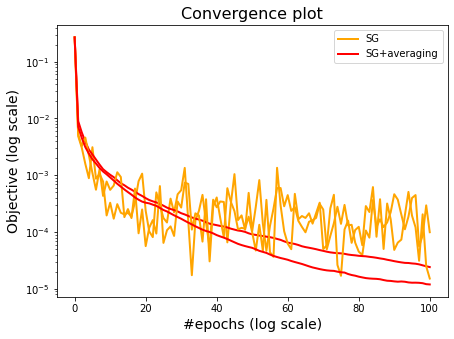

In [14]:
# Comparison of stochastic gradient with and without averaging
nb_epochs = 100
n = pblinreg.n
x0 = np.zeros(d)

nruns = 2

obj_a = np.zeros((nruns,nb_epochs+1))
obj_b = np.zeros((nruns,nb_epochs+1))

nbset = int(n/1000)

for i in range(nruns):
    # Run standard stochastic gradient without averaging
    _, obj_a[i,:], _ = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset, verbose=True)
    # Run stochastic gradient with averaging
    _, obj_b[i,:], _= stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,average=1, verbose=True)

# Plot the results
plt.figure(figsize=(7, 5))
for i in range(nruns-1):
    plt.semilogy(obj_a[i,:]-f_min_lin,color='orange',lw=2)
    plt.semilogy(obj_b[i,:]-f_min_lin,color='red', lw=2)
plt.semilogy(obj_a[-1,:]-f_min_lin,label='SG',color='orange',lw=2)
plt.semilogy(obj_b[-1,:]-f_min_lin,label='SG+averaging',color='red', lw=2)
    
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

Diagonal Scaling

In [15]:
# Comparison of stochastic gradient with and without diagonal scaling

nb_epochs = 60
n = pblinreg.n
x0 = np.zeros(d)

nbset = int(n/500)
n_iter = int(nb_epochs*n/nbset)

# Stochastic gradient (batch size 1) without diagonal scaling
x_a, obj_a, nits_a = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=n_iter,nb=nbset)
# Stochastic gradient (batch size 1) with RMSProp diagonal scaling
x_b, obj_b, nits_b = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=n_iter,nb=nbset,average=0,scaling=1)
# Stochastic gradient (batch size 1) with Adagrad diagonal scaling - Constant step size
x_c, obj_c, nits_c = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0,step0=0.2, n_iter=n_iter,nb=nbset,average=0,scaling=2)
# Stochastic gradient (batch size 1) with Adagrad diagonal scaling - Decreasing step size
x_d, obj_d, nits_d = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=n_iter,nb=nbset,average=0,scaling=2)

Stochastic Gradient, batch size= 33 / 16512
  iter   |   fval   |  normit 
       0 | 4.99e-01 | 1.03e+00
    5504 | 2.31e-01 | 1.23e-01
   11008 | 2.31e-01 | 5.86e-02
   16512 | 2.30e-01 | 3.89e-02
   22016 | 2.30e-01 | 3.77e-02
   27520 | 2.30e-01 | 3.10e-02
   30021 | 2.30e-01 | 2.23e-02
Stochastic Gradient, batch size= 33 / 16512
  iter   |   fval   |  normit 
       0 | 4.99e-01 | 1.03e+00
    5504 | 3.78e-01 | 8.81e-01
   11008 | 3.84e-01 | 8.94e-01
   16512 | 3.73e-01 | 8.58e-01
   22016 | 3.79e-01 | 8.76e-01
   27520 | 3.89e-01 | 9.08e-01
   30021 | 3.82e-01 | 8.87e-01
Stochastic Gradient, batch size= 33 / 16512
  iter   |   fval   |  normit 
       0 | 4.99e-01 | 1.03e+00
    5504 | 2.32e-01 | 1.32e-01
   11008 | 2.31e-01 | 4.94e-02
   16512 | 2.30e-01 | 1.73e-02
   22016 | 2.31e-01 | 3.43e-02
   27520 | 2.30e-01 | 1.27e-02
   30021 | 2.30e-01 | 2.44e-02
Stochastic Gradient, batch size= 33 / 16512
  iter   |   fval   |  normit 
       0 | 4.99e-01 | 1.03e+00
    5504 | 2.60e-0

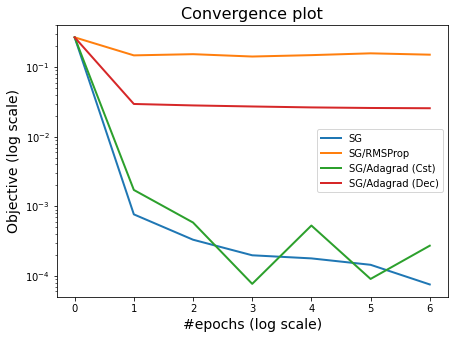

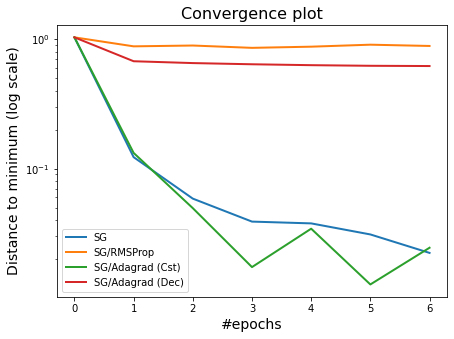

In [16]:
# Plot the results - Comparison of stochastic gradient with and without diagonal scaling
# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="SG", lw=2)
plt.semilogy(obj_b-f_min_lin, label="SG/RMSProp", lw=2)
plt.semilogy(obj_c-f_min_lin, label="SG/Adagrad (Cst)", lw=2)
plt.semilogy(obj_d-f_min_lin, label="SG/Adagrad (Dec)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
# In terms of distance to the minimum (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(nits_a, label="SG", lw=2)
plt.semilogy(nits_b, label="SG/RMSProp", lw=2)
plt.semilogy(nits_c, label="SG/Adagrad (Cst)", lw=2)
plt.semilogy(nits_d, label="SG/Adagrad (Dec)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Distance to minimum (log scale)", fontsize=14)
plt.legend()